# Autoencoders

Import the libraries.

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from torchvision.utils import save_image
from torch.autograd import Variable
from os.path import exists
import torch.nn.functional as F

Utility functions, to store the temporary images and to convert matrix shape.

In [2]:
if not os.path.exists('./vae_img'):
    os.mkdir('./vae_img')
    
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

## Dataset

In [3]:
num_epochs = 100
batch_size = 128
learning_rate = 1e-3

# Transforms images to a PyTorch Tensor
img_transform = transforms.Compose([
    transforms.ToTensor()
])

# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./data", train = True,download = True,transform = img_transform)

# DataLoader is used to load the dataset
# for training
loader = torch.utils.data.DataLoader(dataset = dataset,batch_size = batch_size,shuffle = True)

## Model

In [4]:
class VAE(torch.nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = torch.nn.Linear(784, 400)
        self.fc21 = torch.nn.Linear(400, 2)
        self.fc22 = torch.nn.Linear(400, 2)
        self.fc3 = torch.nn.Linear(2, 400)
        self.fc4 = torch.nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In [5]:
# Model Initialization
model = VAE()
#moving to gpu
if torch.cuda.is_available():
    model.cuda()
    
reconstruction_function = torch.nn.MSELoss(size_average=False)


def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return BCE + KLD


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

/opt/conda/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## Training / Loading

In [6]:
model_file = "vae.pth"

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 0 [0/60000 (0%)]	Loss: 184.081390
Train Epoch: 0 [12800/60000 (21%)]	Loss: 49.355560
Train Epoch: 0 [25600/60000 (43%)]	Loss: 48.907082
Train Epoch: 0 [38400/60000 (64%)]	Loss: 46.834999
Train Epoch: 0 [51200/60000 (85%)]	Loss: 43.791584
====> Epoch: 0 Average loss: 49.4524
Train Epoch: 1 [0/60000 (0%)]	Loss: 43.853298
Train Epoch: 1 [12800/60000 (21%)]	Loss: 40.737587
Train Epoch: 1 [25600/60000 (43%)]	Loss: 42.982132
Train Epoch: 1 [38400/60000 (64%)]	Loss: 42.007309
Train Epoch: 1 [51200/60000 (85%)]	Loss: 41.614185
====> Epoch: 1 Average loss: 42.5358
Train Epoch: 2 [0/60000 (0%)]	Loss: 41.215233
Train Epoch: 2 [12800/60000 (21%)]	Loss: 39.314785
Train Epoch: 2 [25600/60000 (43%)]	Loss: 40.393742
Train Epoch: 2 [38400/60000 (64%)]	Loss: 41.298832
Train Epoch: 2 [51200/60000 (85%)]	Loss: 38.968044
====> Epoch: 2 Average loss: 41.3725
Train Epoch: 3 [0/60000 (0%)]	Loss: 40.673317
Train Epoch: 3 [12800/60000 (21%)]	Loss: 39.246819
Train Epoch: 3 [25600/60000 (43%)]	Loss: 

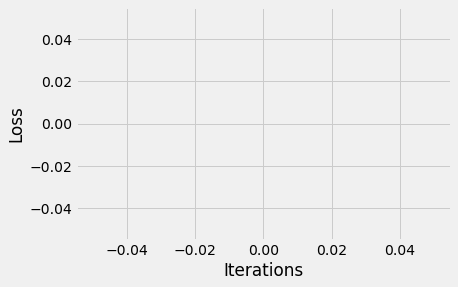

In [7]:
if exists(model_file):
    model.load_state_dict(torch.load(model_file))
    model.eval()
else:
    losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, data in enumerate(loader):
            img, _ = data
            img = img.view(img.size(0), -1)
            img = Variable(img)
            if torch.cuda.is_available():
                img = img.cuda()
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(img)
            loss = loss_function(recon_batch, img, mu, logvar)
            loss.backward()
            train_loss += loss.data
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch,
                    batch_idx * len(img),
                    len(loader.dataset), 100. * batch_idx / len(loader),
                    loss.data / len(img)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(loader.dataset)))
        if epoch % 10 == 0:
            save = to_img(recon_batch.cpu().data)
            save_image(save, './vae_img/image_{}.png'.format(epoch))

        torch.save(model.state_dict(), model_file)
        
    model.eval()
    # Defining the Plot Style
    plt.style.use('fivethirtyeight')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')

    # Plotting the last 100 values
    plt.plot(losses[-100:])

## Display sample images

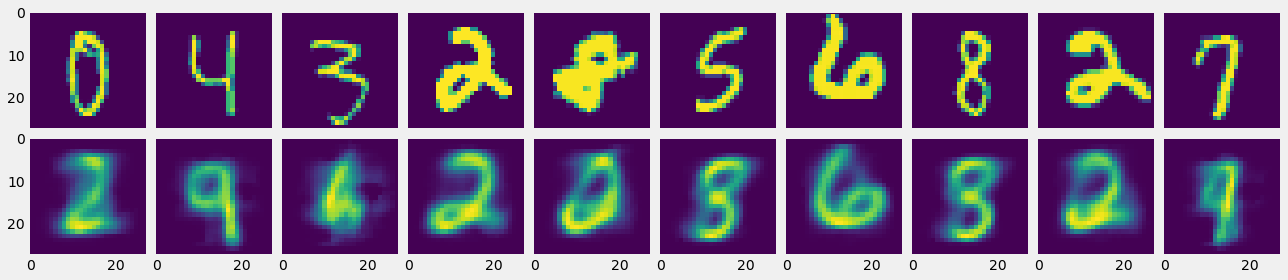

In [12]:
import random
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
model.eval()

fig = plt.figure(figsize=(20., 5.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 10),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


for i in range(10):
    image,_ = dataset.__getitem__(random.randint(1,37000))

    img = image.reshape(-1, 28*28)
    img = Variable(img)
    if torch.cuda.is_available():
        img = img.cuda()    

    reconstructed, _, _ = model(img)
    item = reconstructed.reshape(-1, 28, 28)
    item = item.cpu().detach().numpy()

    # Iterating over the grid returns the Axes.
    grid[i].imshow(image[0])
    grid[i].grid(False)
    grid[10+i].imshow(item[0])
    grid[10+i].grid(False)


plt.savefig("nums_vae.png",transparent=True)
plt.show()


## Display latent space

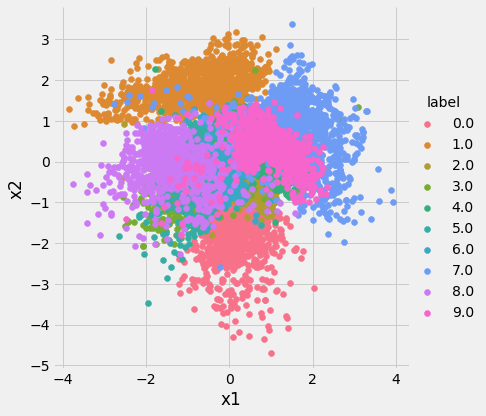

In [15]:
import seaborn as sns
import pandas as pd

latents = []
for i in range(10000):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    img = Variable(img)
    if torch.cuda.is_available():
        img = img.cuda()    

    output,mu,logvar = model(img.reshape(-1,28*28))
    latent = model.reparametrize(mu, logvar)

    latents.append(np.append(latent.cpu().detach().numpy(),label))

latarray = np.stack(latents, axis=0 )
df = pd.DataFrame(data=latarray, columns=("x1", "x2", "label"))
sns.FacetGrid(df, hue="label", height=6).map(plt.scatter, 'x1', 'x2').add_legend()
plt.savefig("latent_space.png",transparent=True)
plt.show()


In [357]:
data_types_dict = {'label': int}
df = df.astype(data_types_dict)
print(df.dtypes)

x1       float64
x2       float64
label      int64
dtype: object


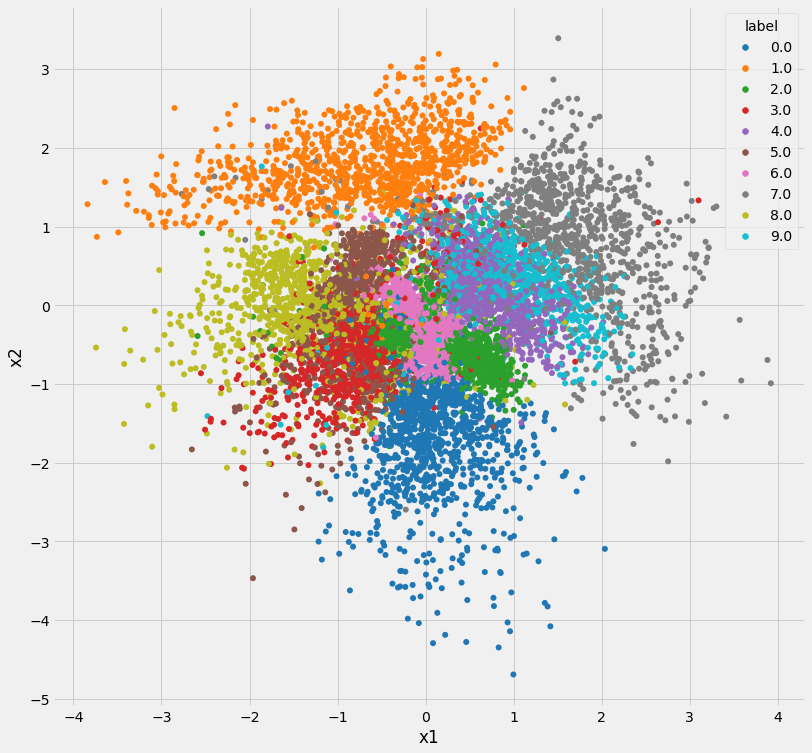

In [16]:
f, ax = plt.subplots(figsize=(12, 12))
#sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="x1", y="x2",
                hue="label",
                legend="full",
                palette="tab10",
                linewidth=0,
                data=df, ax=ax)
plt.savefig("latent_space.png",transparent=True)